In [19]:
!pip install bertopic umap-learn hdbscan

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from umap import UMAP
from bertopic import BERTopic
import hdbscan
import re

In [21]:
class ProductGroupGenerator:
    def __init__(self, min_cluster_size=5, max_clusters=75):
        self.sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
        self.tfidf = TfidfVectorizer(
            max_features=1000,
            stop_words='english',
            ngram_range=(1, 2)
        )
        self.min_cluster_size = min_cluster_size
        self.max_clusters = max_clusters
        
    def preprocess_text(self, text):
        # Convert to lowercase and remove special characters
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', str(text).lower())
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text
        
    def generate_clusters(self, texts, method='combined', n_clusters=None):
        """
        Generate product clusters using different methods
        
        Args:
            texts: List of product titles/descriptions
            method: One of 'tfidf_kmeans', 'bert_topic', or 'combined'
            n_clusters: Optional target number of clusters
        """
        if n_clusters is None:
            n_clusters = min(len(texts) // self.min_cluster_size, self.max_clusters)
            
        processed_texts = [self.preprocess_text(text) for text in texts]
        
        if method == 'tfidf_kmeans':
            return self._cluster_tfidf_kmeans(processed_texts, n_clusters)
        elif method == 'bert_topic':
            return self._cluster_bert_topic(processed_texts)
        elif method == 'combined':
            return self._cluster_combined(processed_texts, n_clusters)
        else:
            raise ValueError("Invalid clustering method")
    
    def _cluster_tfidf_kmeans(self, texts, n_clusters):
        # Transform texts to TF-IDF vectors
        tfidf_matrix = self.tfidf.fit_transform(texts)
        
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(tfidf_matrix)
        
        # Get top terms for each cluster
        cluster_terms = {}
        feature_names = self.tfidf.get_feature_names_out()
        for i in range(n_clusters):
            center_indices = kmeans.cluster_centers_[i].argsort()[::-1][:5]
            cluster_terms[i] = [feature_names[idx] for idx in center_indices]
            
        return labels, cluster_terms
    
    def _cluster_bert_topic(self, texts):
        # Create embeddings
        embeddings = self.sentence_model.encode(texts)
        
        # Initialize BERTopic
        topic_model = BERTopic(
            umap_model=UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine'),
            hdbscan_model=hdbscan.HDBSCAN(
                min_cluster_size=self.min_cluster_size,
                min_samples=1,
                metric='euclidean',
                cluster_selection_method='eom'
            ),
            verbose=True
        )
        
        # Fit the model and get topics
        labels, _ = topic_model.fit_transform(texts, embeddings)
        
        # Get topic terms
        topic_terms = {}
        for topic_idx, words in topic_model.get_topics().items():
            topic_terms[topic_idx] = [word[0] for word in words[:5]]
            
        return labels, topic_terms
    
    def _cluster_combined(self, texts, n_clusters):
        # Get clusters from both methods
        print("CLUSTERING BY KMEANS")
        kmeans_labels, kmeans_terms = self._cluster_tfidf_kmeans(texts, n_clusters)
        print("CLUSTERING BY BERT")
        bert_labels, bert_terms = self._cluster_bert_topic(texts)
        
        # Create ensemble clustering
        # Convert labels to one-hot encoding
        def one_hot_encode(labels):
            n_unique = len(np.unique(labels))
            return np.eye(n_unique)[labels]
        
        kmeans_oh = one_hot_encode(kmeans_labels)
        bert_oh = one_hot_encode(bert_labels)
        
        # Concatenate features
        combined_features = np.hstack([kmeans_oh, bert_oh])
        
        # Final clustering on combined features
        print("CREATING FINAL CLUSTERING COMBINATION")
        final_kmeans = KMeans(n_clusters=n_clusters)
        final_labels = final_kmeans.fit_predict(combined_features)
        
        # Combine terms from both methods for final clusters
        final_terms = {}
        for i in range(n_clusters):
            terms_set = set()
            terms_set.update(kmeans_terms.get(i, []))
            terms_set.update(bert_terms.get(i, []))
            final_terms[i] = list(terms_set)[:5]
            
        return final_labels, final_terms

    def analyze_clusters(self, texts, labels, cluster_terms):
        """
        Analyze cluster quality and characteristics
        """
        cluster_stats = {}
        unique_labels = np.unique(labels)
        
        for label in unique_labels:
            cluster_texts = [texts[i] for i in range(len(texts)) if labels[i] == label]
            cluster_stats[label] = {
                'size': len(cluster_texts),
                'terms': cluster_terms.get(label, []),
                'sample_products': cluster_texts[:3]  # Show 3 example products
            }
            
        return cluster_stats

In [22]:
# Preparing the data
products_df = pd.read_csv('appliances.csv')
texts = products_df['title'] + ' ' + products_df['description']

/var/folders/1b/yssk88t91gqfxx2tk6mrdln40000gn/T/ipykernel_13573/2969233008.py:2: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  products_df = pd.read_csv('appliances.csv')


In [23]:
# Initialize clustering class
generator = ProductGroupGenerator(min_cluster_size=50, max_clusters = 100)

In [24]:
# Run clustering
labels, cluster_terms = generator.generate_clusters(texts, method='combined')

CLUSTERING BY KMEANS
CLUSTERING BY BERT


2025-02-12 23:00:14,923 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-02-12 23:00:43,913 - BERTopic - Dimensionality - Completed ✓
2025-02-12 23:00:43,914 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been us

CREATING FINAL CLUSTERING COMBINATION


In [25]:
# Analyze the clusters
cluster_stats = generator.analyze_clusters(texts, labels, cluster_terms)

In [26]:
# Number of products
products_df.shape[0]

94327

In [27]:
#Number of clusters
len(cluster_stats)

100

In [28]:
# Sample of group sizes and key terms
for i in range(10):
    print(f"Cluster Size: {cluster_stats[i]['size']}")
    print(f"Key Terms: {', '.join(cluster_stats[i]['terms'])}\n")

Cluster Size: 1179
Key Terms: range oven, keurig, range, coffee, cups

Cluster Size: 2915
Key Terms: egg, door, door bin, holder, door shelf

Cluster Size: 81
Key Terms: grease, pure, da29, hood, charcoal

Cluster Size: 24
Key Terms: aftermarket product, authorized aftermarket, surface, product fits, brand models

Cluster Size: 2867
Key Terms: asm, ge, aftermarket, various, ice

Cluster Size: 2924
Key Terms: screen, 796, dryer, ft, refrigerator

Cluster Size: 1664
Key Terms: sticker, water inlet, magnet, magnetic, inlet

Cluster Size: 1339
Key Terms: purposes, replacement, vacuum, pack, compatible

Cluster Size: 8898
Key Terms: coffee, cubes, paper, filters, ice

Cluster Size: 780
Key Terms: geh, washing, washer, pads, hotpoint



In [29]:
num_items = []

for cluster in cluster_stats.keys():
    num_items.append(cluster_stats[cluster]['size'])

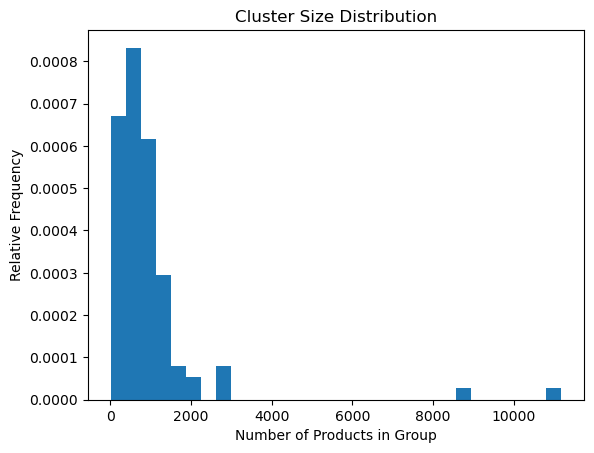

In [30]:
plt.hist(num_items, bins=30, density=True)
plt.title("Cluster Size Distribution")
plt.xlabel("Number of Products in Group")
plt.ylabel("Relative Frequency")
plt.show()

In [31]:
products_df['label'] = labels
products_df['label'].value_counts()[:5]

label
74    11182
8      8898
5      2924
1      2915
4      2867
Name: count, dtype: int64

In [43]:
# Largest Group Info
cluster_stats[74]

{'size': 11182,
 'terms': ['control panel', 'drum', 'we1m504', 'we1m1067', 'panel'],
 'sample_products': ["Whirlpool W10918546 Igniter ['Whirlpool Igniter']",
  'SAMSUNG Cap-Handle Sub Fre L;Nw2 (DA67-02639A) ["Samsung Assembly Cap Handle-Sub Freezer Left NW2-FDR,INO . Manufacturer\'s Product Number: SAM-DA97-11912L"]',
  'Door Knob Cover 4 PCS to Protect Wall, Soft Safety Bumper and Decorative Velvet Cloth Door Handle Covers []']}

In [50]:
products_df.to_csv("labeled_appliances.csv", index=False)